In [2]:
import numpy as np
import gym

import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt 

%matplotlib inline

from toolz import curry, do 
from functools import partial
from copy import deepcopy 

from sklearn.neighbors import NearestNeighbors
from scipy.spatial import distance

In [3]:
import torch
import torch.nn as nn

GPU = False

device = 'cuda:0' if GPU and torch.cuda.is_available() else 'cpu'

print(f'device is {device}')

device is cpu


In [4]:
class LinearPolicy(nn.Module):
    
    def __init__(self, input_dim, output_dim):
        super(LinearPolicy, self).__init__()
        
        self.net = torch.nn.Sequential(
            torch.nn.Linear(input_dim, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, output_dim)).to(device)
        
    def forward(self, x):
        action_values = self.net(x)
        
        return action_values

In [5]:
class Agent():
    def __init__(self, policy):
        self.policy = policy
        
    def act(self, observation):
        action_values = self.policy.forward(torch.Tensor(observation).to(device))
        action = torch.argmax(action_values).item()

        return action

In [6]:
def episode(env: gym.Env, agent: Agent, visualize=False):
    rewards = 0
    
    observation = env.reset()
    done = False
    
    while not done:
        if visualize:
            env.render()
            
        action = agent.act(observation)
        observation, reward, done, info = env.step(action)
        rewards += reward
        
    return rewards

In [7]:
env = gym.make('CartPole-v0')

policy = LinearPolicy(sum(env.observation_space.shape), env.action_space.n)
agent = Agent(policy)

print(f'Sum rewards: {episode(env, agent, visualize=False)}')

Sum rewards: 9.0


In [13]:
class GA:
    
    def __init__(self, pop_size, survivors_selector, mutator, initializer, fitness):
        self.pop_size = pop_size
        self.initializer = initializer
        self.mutator = mutator
        self.fitness = fitness
        self.survivors_selector = survivors_selector
        
        self.population = None
        self.population_fitness = None
        self.elite = None
        self.elite_fitness = None
        
    def next_generation(self):
        if not self.population:
            self.population = [self.initializer() for _ in range(self.pop_size)]
        else:
            survivors = self.survivors_selector(self.population, self.population_fitness)
            parents = np.random.choice(survivors, self.pop_size - 1, replace=True) # 1 for the elite
            
            children = [do(self.mutator, deepcopy(parent)) for parent in parents]
            self.population = [self.elite] + children # elitism - elite stays as is without mutations
            
        self.population_fitness = [self.fitness(specimen) for specimen in tqdm(self.population)]
        
        elite_idx = np.argmax(self.population_fitness)
        self.elite = self.population[elite_idx]
        self.elite_fitness = self.population_fitness[elite_idx]

In [14]:
@curry
def fitness(robustness, env, specimen):
    episode_rewards = [episode(env, specimen) for _ in range(robustness)]
    
    return sum(episode_rewards) / len(episode_rewards)

def initializer(env):
    policy = LinearPolicy(sum(env.observation_space.shape), env.action_space.n)
    agent = Agent(policy)
    
    return agent

@curry
def mutator(mutation_strength, agent):
    genome = nn.utils.parameters_to_vector(agent.policy.parameters())
    noise = torch.randn(genome.shape).to(device) * mutation_strength
    
    genome += noise
    torch.nn.utils.vector_to_parameters(genome, agent.policy.parameters())
    
@curry
def survivors_selection(truncation_len, population, fitnesses):
    fitness_pop = sorted(zip(fitnesses, population), reverse=True, key=lambda fit_pop: fit_pop[0])
    pop = [specimen for fit, specimen in fitness_pop]
    
    return pop[:truncation_len]

In [15]:
popsize = 50
mutation_strength = 0.003
truncation_length = 10
fit_robustness = 5
n_generations = 20

env = gym.make('Acrobot-v1')

In [16]:
torch.autograd.set_grad_enabled(False)

fitness_log = []
ga = GA(
    pop_size=popsize,
    initializer=partial(initializer, env),
    fitness=fitness(fit_robustness, env),
    survivors_selector = survivors_selection(truncation_length),
    mutator=mutator(mutation_strength)
)

for gen in tqdm(range(n_generations)):
    ga.next_generation()
    print(f'generation {gen} fitness {ga.elite_fitness}')
    fitness_log.append(ga.elite_fitness)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

generation 0 fitness -96.0


  0%|          | 0/50 [00:00<?, ?it/s]

generation 1 fitness -89.6


  0%|          | 0/50 [00:00<?, ?it/s]

generation 2 fitness -85.2


  0%|          | 0/50 [00:00<?, ?it/s]

generation 3 fitness -81.6


  0%|          | 0/50 [00:00<?, ?it/s]

generation 4 fitness -80.0


  0%|          | 0/50 [00:00<?, ?it/s]

generation 5 fitness -75.8


  0%|          | 0/50 [00:00<?, ?it/s]

generation 6 fitness -70.8


  0%|          | 0/50 [00:00<?, ?it/s]

generation 7 fitness -71.6


  0%|          | 0/50 [00:00<?, ?it/s]

generation 8 fitness -70.4


  0%|          | 0/50 [00:00<?, ?it/s]

generation 9 fitness -68.2


  0%|          | 0/50 [00:00<?, ?it/s]

generation 10 fitness -70.4


  0%|          | 0/50 [00:00<?, ?it/s]

generation 11 fitness -70.0


  0%|          | 0/50 [00:00<?, ?it/s]

generation 12 fitness -72.2


  0%|          | 0/50 [00:00<?, ?it/s]

generation 13 fitness -71.0


  0%|          | 0/50 [00:00<?, ?it/s]

generation 14 fitness -72.4


  0%|          | 0/50 [00:00<?, ?it/s]

generation 15 fitness -68.4


  0%|          | 0/50 [00:00<?, ?it/s]

generation 16 fitness -66.8


  0%|          | 0/50 [00:00<?, ?it/s]

generation 17 fitness -67.4


  0%|          | 0/50 [00:00<?, ?it/s]

generation 18 fitness -70.8


  0%|          | 0/50 [00:00<?, ?it/s]

generation 19 fitness -69.4


<AxesSubplot:xlabel='generation', ylabel='fitness'>

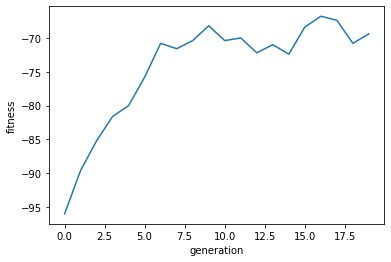

In [17]:
sns.lineplot(data={
    'generation': [gen for gen in range(n_generations)],
    'fitness': fitness_log,},
    x='generation',
    y='fitness')